In [1]:
import numpy as np
from scipy.linalg import fractional_matrix_power, cholesky, cho_solve
from scipy.special import erf
import matplotlib.pyplot as plt
from scipy.stats import norm
import GPy

In [2]:
class SquaredExponentialKernel:
    def __init__(self, l, sigmaf):
        self.l = l
        self.sigmaf = sigmaf
        
    def __call__(self, x, xstar = None):
        
        if xstar is not None:
            K = np.zeros((len(x), len(xstar)))

            for i in range(len(xstar)):
                temp = np.repeat(np.reshape(xstar[i,:],(1,-1)), len(x), axis = 0)
                dist = np.sum((x-temp)**2, axis = 1)
                K[:,i] = self.sigmaf**2*np.exp(-dist/(2*(self.l**2)))
        else:
            K = np.zeros((len(x), len(x)))

            for i in range(len(x)):
                temp = np.repeat(np.reshape(x[i,:],(1,-1)), len(x), axis = 0)
                dist = np.sum((x-temp)**2, axis = 1)
                K[:,i] = self.sigmaf**2*np.exp(-dist/(2*(self.l**2)))
            
        return K

In [3]:
test = open('zip.test')
train = open('zip.train')
x_test = []
y_test = []
x_train = []
y_train = []

for line in test:
    numbers = line.split(' ')
    obs = np.zeros(len(numbers)-1)
    j = 0
    for num in numbers[1::]:
        temp = num.split("\n")
        obs[j] = float(temp[0])
        j+=1
    x_test.append(obs)
    y_test.append(float(numbers[0]))

for line in train:
    numbers = line.split(' ')
    obs = np.zeros(len(numbers)-2)
    j = 0
    for num in numbers[1::]:
        if not num == '\n':
            obs[j] = float(num)
        j+=1
    x_train.append(obs)
    y_train.append(float(numbers[0]))

x_test = np.array(x_test)
y_test = np.array(y_test)

x_train = np.array(x_train)
y_train = np.array(y_train)

In [4]:
collect = np.append(x_train, x_test, axis = 0)
y_collect = np.append(y_train, y_test, axis = 0)
idx_x_train = np.random.choice(list(range(len(collect))), size = int(len(collect)/2))
x_train_new = collect[idx_x_train,:]
x_test_new = collect[~idx_x_train,:]
y_train_new = y_collect[idx_x_train]
y_test_new = y_collect[~idx_x_train]

x_train_35 = x_train_new[(y_train_new==3.0) | (y_train_new==5.0)]
x_test_35 = x_test_new[(y_test_new==3.0) | (y_test_new==5.0)]
y_train_35 = y_train_new[(y_train_new==3.0)|(y_train_new==5.0)]
y_test_35 = y_test_new[(y_test_new==3.0)|(y_test_new==5.0)]

In [5]:
from scipy.stats import multivariate_normal

def logistic_likelihood(f,y):
    pi = 1/(1+np.exp(-f))
    W = pi*(1-pi)
    ti = (y+1)/2
    grad = ti - pi
    return grad, W

def probit_likelihood(f,y):
    dist = multivariate_normal.cdf(y*f)
    n_f = 1/((2*np.pi)**(len(f)/2))*np.exp(-1/2*f**2)
    grad = y*n_f/dist
    W = n_f**2/dist**2+y*f*n_f/dist
    return grad, W

In [6]:
def Algorithm31(K, y, likelihood, maxiter, tol):
    f = np.zeros(len(y))
    i = 0
    log_marginal_likelihood = -np.inf
    while True:
        grad, W = likelihood(f,y)
        W_sr = np.sqrt(W)
        W_sr_K = W_sr[:, np.newaxis] * K
        L = cholesky(np.identity(len(K))+W_sr_K*W_sr, lower =True)
        b = W*f + grad
        a = b -  W_sr * cho_solve((L, True), W_sr_K.dot(b))
        f_new = K.dot(a)
        i+=1
        diff = np.mean(abs(f-f_new))
        f = f_new
        pyf = np.log1p(np.exp(-(y * 2 - 1) * f)).sum()
        lml = -1/2 * a.T.dot(f) - np.sum(pyf) - np.sum(np.log(np.diag(L)))  
        if i>maxiter or lml - log_marginal_likelihood < tol:
            log_marginal_likelihood = lml
            break
        log_marginal_likelihood = lml
    
    return f, i, diff, log_marginal_likelihood

In [101]:
def Algorithm32(fhat, X, y, kernel, likelihood, xstar):
    from scipy.special import erf
    
    grad, W = likelihood(fhat,y)
    W_sr = np.sqrt(W)
    K = kernel(X,X)
    W_sr_K = W_sr[:, np.newaxis] * K    
    L = cholesky(np.identity(len(K))+W_sr_K*W_sr, lower = True)
    kstar = kernel(X, xstar)
    kstarstar = kernel(xstar, xstar)
    fstar = np.transpose(kstar).dot(grad)
    v = np.linalg.solve(L, W_sr[:, np.newaxis] * kstar)
    V_fstar = kstarstar - np.matmul(v.T,v) 
    
    #compute integral 
    LAMBDAS = np.array([0.41, 0.4, 0.37, 0.44, 0.39])[:, np.newaxis]
    COEFS = np.array([-1854.8214151, 3516.89893646, 221.29346712,
                      128.12323805, -2010.49422654])[:, np.newaxis]
    alpha = 1 / (2 * np.diag(V_fstar))
    gamma = LAMBDAS * fstar
    integrals = np.sqrt(np.pi / alpha) \
        * erf(gamma * np.sqrt(alpha / (alpha + LAMBDAS**2))) \
        / (2 * np.sqrt(np.diag(V_fstar) * 2 * np.pi))
    pi_star = (COEFS * integrals).sum(axis=0) + .5 * COEFS.sum()

    return fstar, pi_star

In [227]:
def Algorithm35(K, y, maxiter, tol = 1e-6):
    tnu = np.zeros(len(y))
    ttau = np.zeros(len(y))
    sigma = K
    mu = np.zeros(len(y))
    tauMI = np.zeros(len(y))
    nuMI = np.zeros(len(y))
    muMI = np.zeros(len(y))
    lml = -np.inf # initialize marginal loglikelihood
    
    random_shuffle = list(range(len(y)))
    np.random.shuffle(random_shuffle)
    iter=0
    while True:
        for i in random_shuffle:
            # approximate cavity parameters
            tauMI[i] = 1/sigma[i,i] - ttau[i]
            nuMI[i] = 1/sigma[i,i]*mu[i] - tnu[i]

            # marginal moments
            muMI[i] = nuMI[i]/tauMI[i]
            zi = y[i]*muMI[i]/np.sqrt((1+1/tauMI[i]))
            
            n_zi = norm.pdf(zi)
            phi_zi = norm.cdf(zi)
            
            sigHI = 1/tauMI[i] - 1/(tauMI[i]**2)*n_zi/((1+1/tauMI[i])*phi_zi)*(zi+n_zi/phi_zi)
            muHI = muMI[i] + y[i]*1/tauMI[i]*n_zi/(phi_zi*np.sqrt(1+1/tauMI[i]))

            #update site parameters
            deltatau = 1/sigHI - tauMI[i] - ttau[i]
            #store old versions to check for convergence
            oldttau = ttau
            oldtnu = tnu
            #update
            ttau[i] = np.max(ttau[i] + deltatau, 0.01)
            tnu[i] = 1/sigHI * muHI - nuMI[i]

            #update sigma and mu
            s = sigma[:,i]
            sigma = sigma - (deltatau**(-1) + sigma[i,i])**(-1) * np.dot(s[:, None], s[None, :])    
            mu = np.matmul(sigma, tnu)
            
        S12 = np.diag(ttau)**(1/2)
        S12K = np.dot(S12, K)
        SKS = np.dot(S12K, S12)
        L = cholesky(np.identity(len(y)) + SKS, lower = True)
        V = np.linalg.solve(L, S12K)
        sigma = K - np.dot(V.T, V)
        mu = np.dot(sigma, tnu)
        
        iter +=1
        if iter == maxiter or (np.mean(np.square(oldttau-ttau))<tol) and (np.mean(np.square(oldtnu-tnu))<tol):
            break
            
    #compute the marginal likelihood
    T = np.diag(tauMI)

    #eq. 3.73
    eq373 = 1/2*np.sum(np.log(1 + ttau*1/tauMI)) - np.sum(np.log(np.diag(L)))

    #eq. 3.74
    S12 = np.diag(ttau)**(1/2)
    temp = cho_solve((L, True), S12K)
    temp = np.dot(np.dot(K, S12),temp)
    TSinv = np.diag((tauMI + ttau)**(-1))
    eq374 = 1/2*np.dot(np.dot(tnu.T, K - temp - TSinv), tnu)

    #eq. 3.75
    eq375 = 1/2*np.dot(muMI*tauMI*np.diag(TSinv), ttau*muMI - 2*tnu)

    #third term in 3.65
    zi = y*muMI/np.sqrt(1+1/tauMI)
    term3 = np.sum(norm.logcdf(zi))

    logZep = eq373  + eq374 + term3 + eq375

    return tnu, ttau, logZep, iter

In [228]:
def Algorithm36(tnu, ttau, X, y, kernel, xstar):
    K = kernel(X) # compute kernel between training points
    Kstar = kernel(X, xstar) # compute kernel between training and test point
    Kstarstar = kernel(xstar) # compute kernel between test points
    
    S12 = np.diag(ttau)**(1/2)
    S12K = np.dot(S12, K)
    SKS = np.dot(S12K, S12)
    L = cholesky(np.identity(len(y)) + SKS, lower = True)
    
    temp = np.dot(S12K, tnu)
    z = np.dot(S12, cho_solve((L, True), temp))
    
    fstar = np.dot(Kstar.T, (tnu - z))
    v = np.linalg.solve(L, np.dot(S12, Kstar))
    Var = Kstarstar - np.dot(v.T,v)
    pi = norm.cdf(fstar/np.sqrt(1+np.diag(Var)))
    
    return pi, fstar

In [263]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier

kernel = SquaredExponentialKernel(l = np.exp(2.6), sigmaf = np.exp(4.1))
K = kernel(x_train_35, x_train_35)
yfunc = np.vectorize(lambda x: 1 if x == 3 else -1)
y = yfunc(y_train_35)
yt = yfunc(y_test_35)

In [264]:
# test Laplace approximation
f = Algorithm31(K, y, logistic_likelihood, 100, 1e-10)
fhat =f[0]
fstar_lp, pi_star_lp = Algorithm32(fhat, x_train_35, y, kernel, 
                                   logistic_likelihood, x_test_35)

In [271]:
# test EP algorithm
tnu, ttau, logZep, iter = Algorithm35(K, y, 5, 1e-6)
pi_ep, fstar_ep = Algorithm36(tnu, ttau, x_train_35, y, kernel, x_test_35)

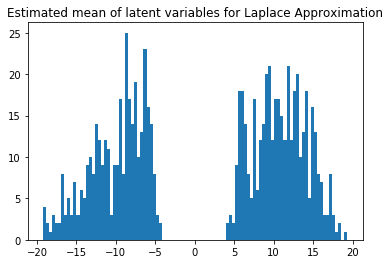

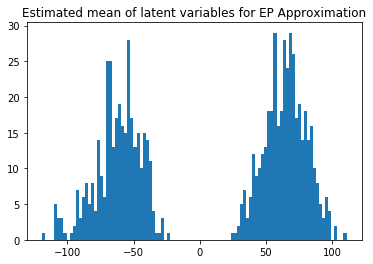

In [272]:
plt.hist(fhat, bins = 100)
plt.title('Estimated mean of latent variables for Laplace Approximation')
plt.show()
plt.title('Estimated mean of latent variables for EP Approximation')
plt.hist(tnu/ttau, bins = 100)
plt.show()

In [241]:
lengthscales = np.exp(np.arange(0,5,step = 0.1))
sigmafs = np.exp(np.arange(0,5,step = 0.1))

logliks_laplace = np.zeros((len(lengthscales), len(sigmafs)))
logliks_ep = np.zeros((len(lengthscales), len(sigmafs)))

for (i, l) in enumerate(lengthscales):
    print(i+1, 'out of', len(lengthscales))
    for (j, sigmaf) in enumerate(sigmafs):
        kernel = sigmaf**2*RBF(l)
        K = kernel(x_train_35)
        f_lp = Algorithm31(K, y, logistic_likelihood, 100, 1e-10)
        f_ep = Algorithm35(K, y, 5, 1e-10)
        logliks_laplace[i,j] = f_lp[3]
        logliks_ep[i,j] = f_ep[2]
np.save('logliks_laplace', logliks_laplace)
np.save('logliks_ep', logliks_ep)

1 out of 50
2 out of 50
3 out of 50
4 out of 50
5 out of 50
6 out of 50
7 out of 50
8 out of 50
9 out of 50
10 out of 50
11 out of 50
12 out of 50
13 out of 50
14 out of 50
15 out of 50
16 out of 50
17 out of 50
18 out of 50
19 out of 50
20 out of 50
21 out of 50
22 out of 50
23 out of 50
24 out of 50
25 out of 50
26 out of 50
27 out of 50
28 out of 50
29 out of 50
30 out of 50
31 out of 50
32 out of 50
33 out of 50
34 out of 50
35 out of 50
36 out of 50
37 out of 50
38 out of 50
39 out of 50
40 out of 50
41 out of 50
42 out of 50
43 out of 50
44 out of 50
45 out of 50
46 out of 50
47 out of 50
48 out of 50
49 out of 50
50 out of 50


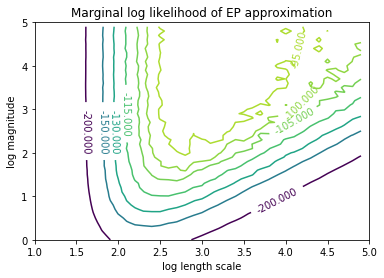

In [255]:
lvls = [-200, -150, -130, -115, -105, -100, -95, -80]
fig, ax = plt.subplots()
CS = ax.contour(np.log(sigmafs), np.log(lengthscales), logliks_ep.T, levels = lvls)
plt.xlim([1,5])
plt.ylim([0, 5])
ax.clabel(CS, np.array(lvls).astype(int), inline=True, fontsize=10)
plt.title('Marginal log likelihood of EP approximation')
plt.xlabel('log length scale')
plt.ylabel('log magnitude')
plt.show()

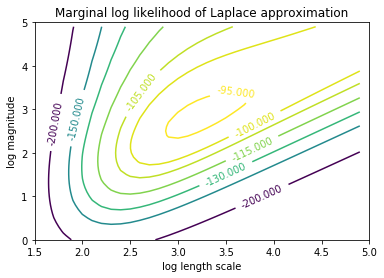

In [254]:
lvls = [-200, -150, -130, -115, -105, -100, -95]
fig, ax = plt.subplots()
CS = ax.contour(np.log(sigmafs), np.log(lengthscales), logliks_laplace.T, levels = lvls)
plt.xlim([1.5,5])
plt.ylim([0, 5])
ax.clabel(CS, np.array(lvls).astype(int), inline=True, fontsize=10)
plt.title('Marginal log likelihood of Laplace approximation')
plt.xlabel('log length scale')
plt.ylabel('log magnitude')
plt.show()

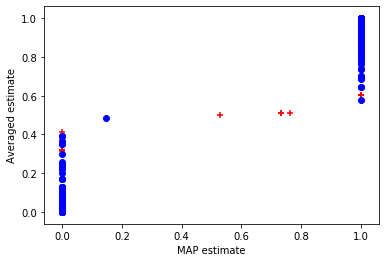

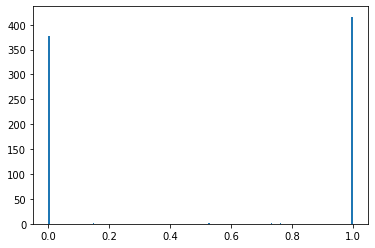

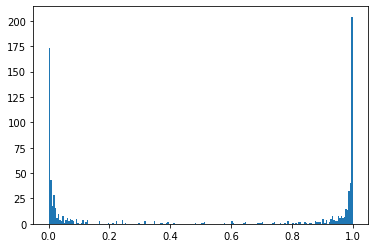

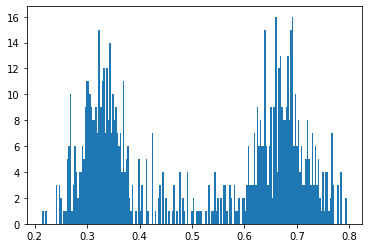

In [274]:
# get MAP predictions and posterior predictions. (figure 3.9)
map_ep = norm.cdf(fstar_ep)
mis_class = ((yt == 1) != (map_ep>0.5))
cor_class = ((yt == 1) == (map_ep>0.5))

plt.scatter(map_ep[mis_class], pi_ep[mis_class], c= 'r', marker = '+')
plt.scatter(map_ep[cor_class], pi_ep[cor_class], c= 'b', marker = 'o')
plt.xlabel('MAP estimate')
plt.ylabel('Averaged estimate')
plt.show()

plt.hist(map_ep, bins = 200)
plt.show()

plt.hist(pi_ep, bins = 200)
plt.show()

plt.hist(pi_star_lp, bins = 200)
plt.show()

In [281]:
# get error-reject curve
prob_laplace = np.concatenate((pi_star_lp[:,np.newaxis], (1-pi_star_lp)[:, np.newaxis]), axis =1)
prob_ep = np.concatenate((pi_ep[:,np.newaxis], (1-pi_ep)[:, np.newaxis]), axis =1)

In [282]:
prob_ep.shape

(799, 2)